# Importing Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tensorflow Version 2.15.0


# Reading Dataset

In [ ]:
# Reading a TSV file
df = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t')

df.columns = ['sentiment', 'text']
df.head()

# Displaying the dataframes
print("TSV DataFrame:")
df

TSV DataFrame:


,sentiment,text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,4,@Covergirl08 I take pride in what I do
159998,4,heading to work on the 6


In [ ]:
# Rename sentiment label

lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Positive,"@elephantbird Hey dear, Happy Friday to You A..."
1,Positive,Ughhh layin downnnn Waiting for zeina to co...
2,Negative,"@greeniebach I reckon he'll play, even if he's..."
3,Negative,@vaLewee I know! Saw it on the news!
4,Negative,very sad that http://www.fabchannel.com/ has c...


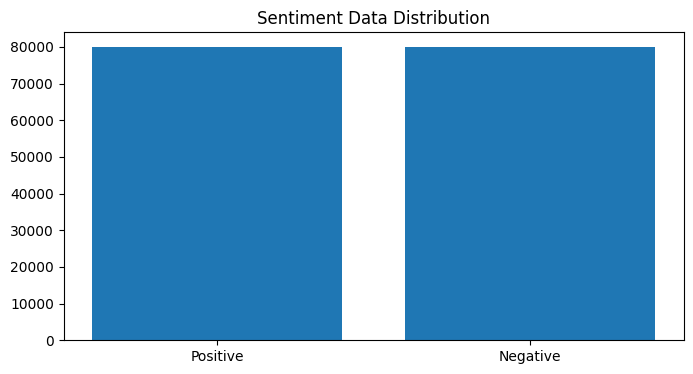

In [ ]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")
plt.savefig("dataset distribution.png")

In [ ]:
val_count

Positive    80000
Negative    80000
Name: sentiment, dtype: int64

# Text Processing

## Stemming/Lematization

For grammatical reasons, documents are going to use different forms of a word, such as write, writing and writes. Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

## Hyperlinks and Mentions

Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.

Twitter User Mentions - Eg. @arunrk7, @andrewng
Hyperlinks - Eg. https://keras.io, https://tensorflow.org

## Stopwords

Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are I, me, myself, you, he, she, we, they, it, and etc

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

## Positive Words

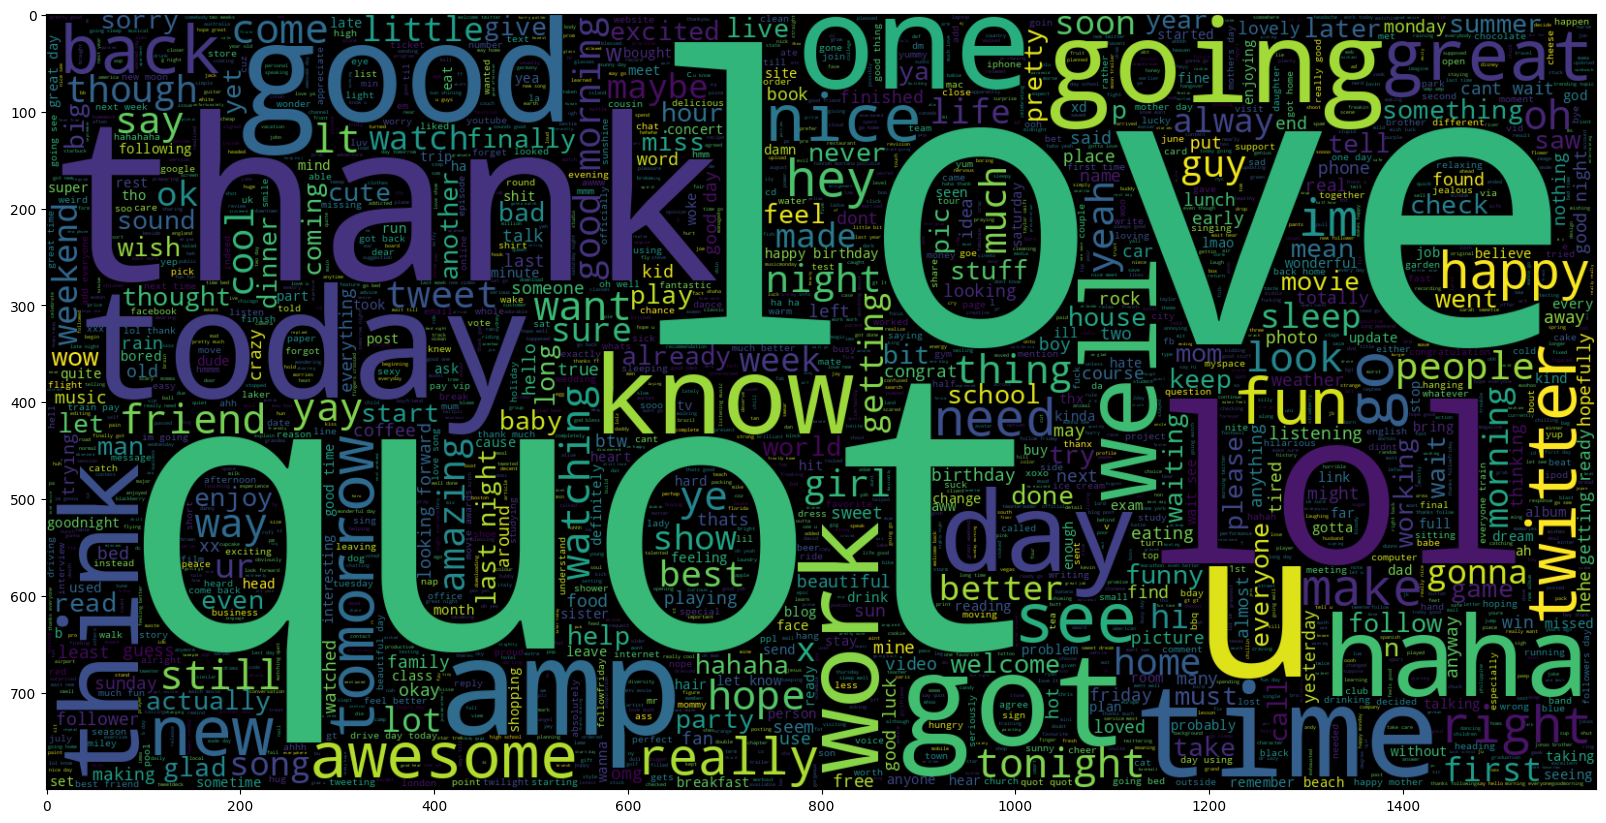

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.savefig("positive words distribution.png")
plt.imshow(wc , interpolation = 'bilinear')

## Negative Words

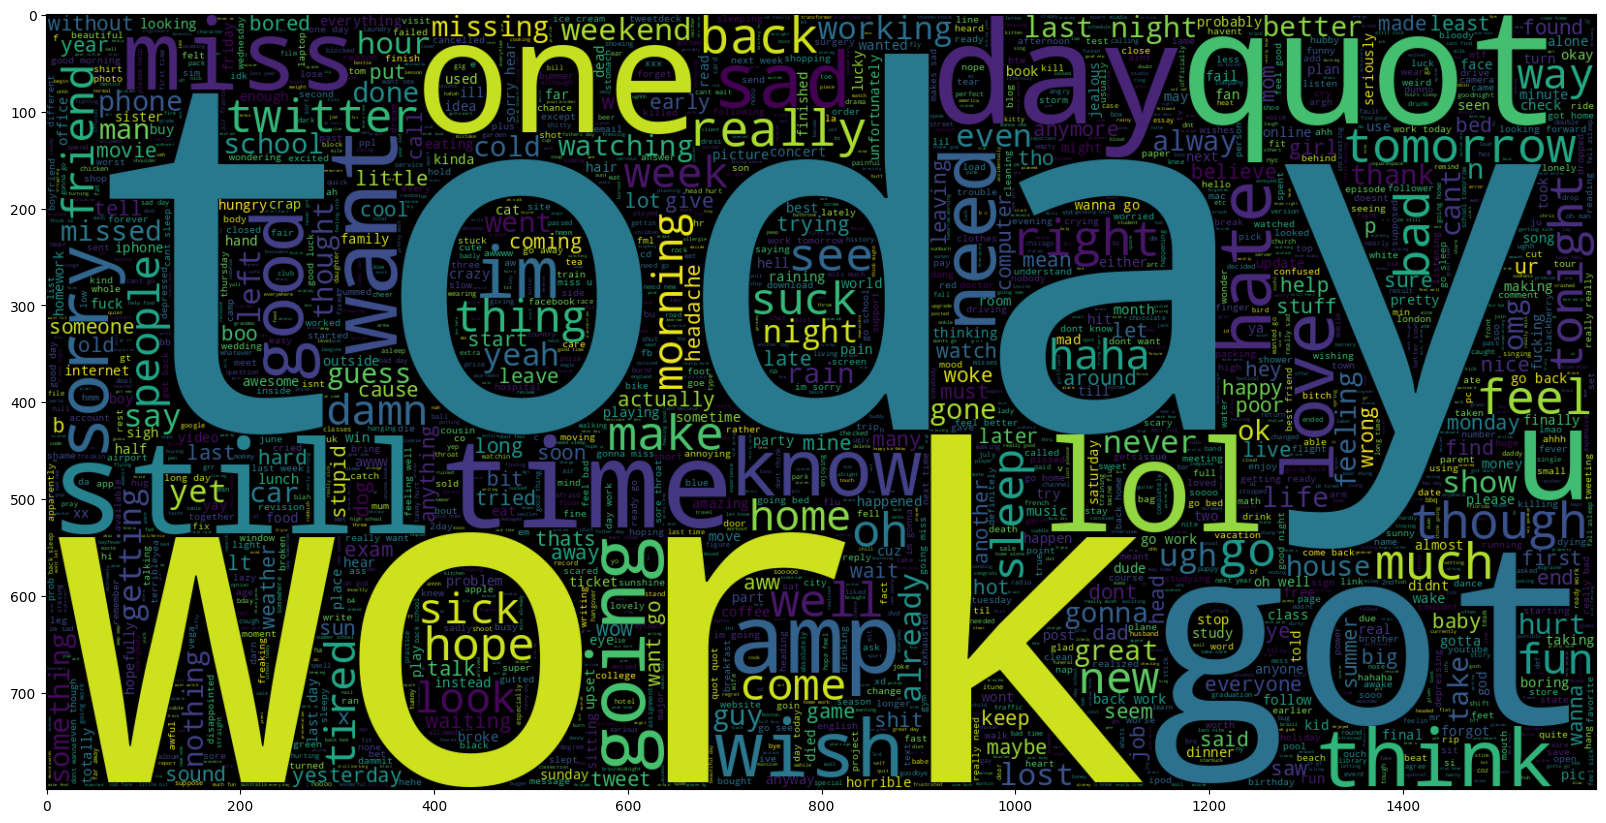

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.savefig("negative words distribution.png")
plt.imshow(wc , interpolation = 'bilinear')

## Train and Test Split

In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [ ]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 128000
Test Data size 32000


In [ ]:
train_data.head(10)

,sentiment,text
156728,Positive,love soo soo much
14488,Negative,early go brother fencing competition happybday...
146215,Positive,well done djing tonight fun even tough bit qui...
81083,Negative,hey watched u live like working stopped
96195,Negative,tragedy best quot math quot friend 3 years dam...
62376,Positive,september 14th 3 5 weeks bene already
15018,Positive,yayayayayay wooo excitedd im sure look amazing...
83658,Positive,hahaha omg cant wait meet go high forget troubles
119186,Positive,whose lying bitch
157077,Negative,new kitty looking pretty sick gonna call human...


## Tokenization

Tokenization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. The process is called Tokenization.

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 67223


Now we got a tokenizer object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length MAX_SEQUENCE_LENGTH.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (128000, 30)
Testing X Shape: (32000, 30)


In [ ]:
labels = train_data.sentiment.unique().tolist()

## Label Encoding

We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.



In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


y_train shape: (128000, 1)
y_test shape: (32000, 1)


## Word Emdedding

In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.

Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification. If you want to learn more about the Word Embedding, please refer some links that I left at the end of this notebook.

In [ ]:
# Check if the file already exists
if not os.path.exists("glove.6B.zip"):
    # If the file doesn't exist, download it
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip
else:
    print("File glove.6B.zip already exists, skipping download.")

File glove.6B.zip already exists, skipping download.


In [ ]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 20
MODEL_PATH = 'best_model.hdf5'

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Training

## LSTM

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)
# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           20166900  
                                                                 
 spatial_dropout1d (Spatial  (None, 30, 300)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               66048 

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/20
125/125 [==============================] - 193s 1s/step - loss: 0.5822 - accuracy: 0.6884 - val_loss: 0.5407 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 184s 1s/step - loss: 0.5348 - accuracy: 0.7279 - val_loss: 0.5233 - val_accuracy: 0.7381 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 181s 1s/step - loss: 0.5120 - accuracy: 0.7445 - val_loss: 0.5122 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 184s 1s/step - loss: 0.4974 - accuracy: 0.7559 - val_loss: 0.5135 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 182s 1s/step - loss: 0.4839 - accuracy: 0.7636 - val_loss: 0.5097 - val_accuracy: 0.7502 - lr: 0.0010
Epoch 6/20
125/125 [==============================] - 182s 1s/step - loss: 0.4713 - accuracy: 0.7734 - val_loss: 0.5109 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 7/20
125/125 [==============================] - 183s 1s/st

# Model Evaluation

## LSTM

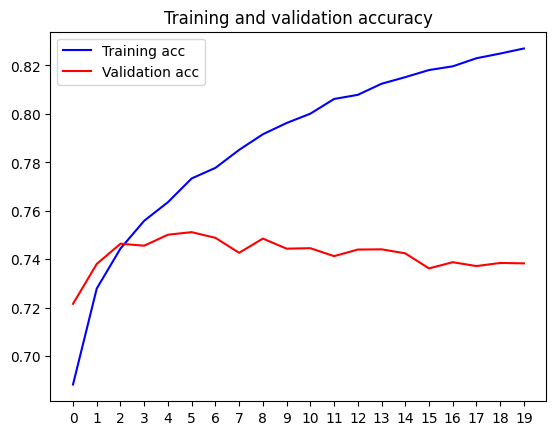

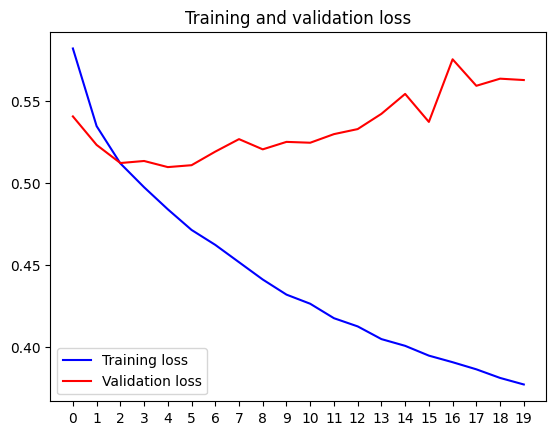

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xticks(range(0, 20))
plt.savefig("accuracy_LSTM_"+str(TRAIN_SIZE)+"_split.png")
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xticks(range(0, 20))
plt.savefig("loss_LSTM_"+str(TRAIN_SIZE)+"_split.png")
plt.show()

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

4/4 [==============================] - 16s 3s/step


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cf_matrix, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title, fontsize=20)
    # plt.colorbar()
    # tick_marks = np.arange(len(classes))
    # plt.xticks(tick_marks, classes, fontsize=13)
    # plt.yticks(tick_marks, classes, fontsize=13)

    # fmt = '.2f'
    # thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, format(cm[i, j], fmt),
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")

    # plt.ylabel('True label', fontsize=17)
    # plt.xlabel('Predicted label', fontsize=17)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

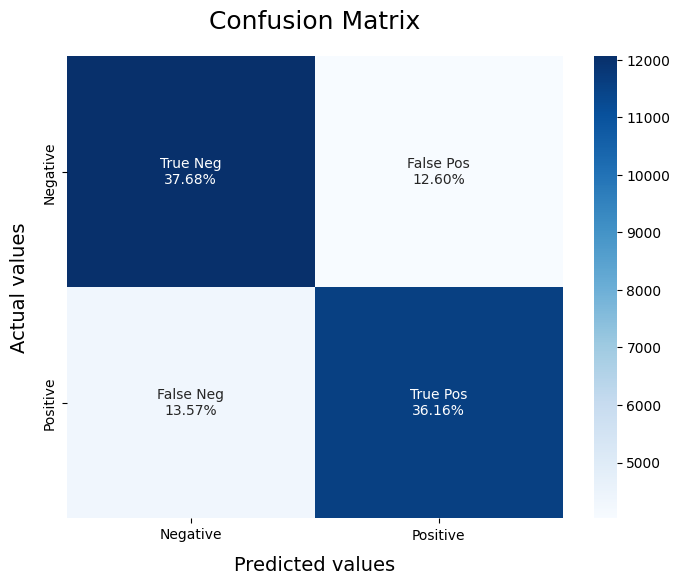

In [ ]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.savefig("confusion_matrix_"+str(TRAIN_SIZE)+"_split.png")
plt.show()

In [ ]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.74      0.75      0.74     16088
    Positive       0.74      0.73      0.73     15912

    accuracy                           0.74     32000
   macro avg       0.74      0.74      0.74     32000
weighted avg       0.74      0.74      0.74     32000



It's a pretty good model we trained here in terms of NLP. Around 80% accuracy is good enough considering the baseline human accuracy also pretty low in these tasks. Also, you may go on and explore the dataset, some tweets might have other languages than English. So our Embedding and Tokenizing wont have effect on them. But on practical scenario, this model is good for handling most tasks for Sentiment Analysis.